# Background: TMDB Data

The Movie DataBase curates information about films... similar to IMDB but with a public API. 

Two different approaches will be used to analyze the dataset. In the first approach, we will attempt to to predict movie revenue based on data related to the film's production, cast and crew, budget, and popularity. By identifying the factors that predict revenue, and predicting the success of a film as measured by revenue, this information could be useful for production companies and directors who make decisions about investing resources in films. In general, the strategy applied to this exercise could be transfered to other domains.

The first approach involves a regression problem, so we will evaluate models including k-Known Neighbors regression, Ridge and Lasso Regression, Random Forest regression, Support Vector regression, and gradient boosting regression, where computationally feasible. The second approach consists of a classification problem: how can we predict "sleeper hits", namely, films with relatively low budgets which nonetheless are financially successful?

Because the dataset includes some natural language fields, which will be mapped to binarized vectors, models that can handle a large feature space and sparce matrices will probably perform best. We will embed feature selection in our models wherever possible, to reduce the effect of random noise. 

We will take the following approach:

- Description of the dataset
- Data cleaning and restructuring 
- Feature selection
- Modeling and model evaluation
- Feature set re-evaluation


## Read in, shape, and clean the data

In [212]:
#Basic
import pandas as pd
import json
import numpy as np

#Math
import math
import statsmodels.api as sm
from math import sqrt

#Visualization
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
from IPython.display import Image
import pydotplus
import graphviz

#Modeling
import sklearn
from sklearn import preprocessing, linear_model, neighbors, tree, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.svm import SVR, LinearSVR, SVC, LinearSVC

#Validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#Model evaluation
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error


In [213]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [214]:
movies = load_tmdb_movies('/Users/teresaoneill/Dropbox/Thinkful/Datasets/tmdb_5000_movies.csv')
credits = load_tmdb_credits('/Users/teresaoneill/Dropbox/Thinkful/Datasets/tmdb_5000_credits.csv')

In [215]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [216]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de..."
3,49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de..."
4,49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de..."


In [217]:
def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

In [218]:
movies2['gender_of_lead'] = credits.cast.apply(lambda x: safe_access(x, [0, 'gender']))
movies2['lead'] = credits.cast.apply(lambda x: safe_access(x, [0, 'name']))
movies2['gender_of_lead2'] = credits.cast.apply(lambda x: safe_access(x, [1, 'gender']))
movies2['lead2'] = credits.cast.apply(lambda x: safe_access(x, [1, 'name']))
movies2.head(3)

,budget,id,original_language,popularity,revenue,runtime,title,vote_average,vote_count,Australia,...,year,month,day,Annual Average,Annual Percent Change,CPI,budget_adj,revenue_adj,hit,sleeper
0,237000000,19995,en,150.437577,2787965087,162.0,Avatar,7.2,11800,0,...,2009,12,10,214.5,-0.40%,1.140793,2.703678e+08,3.180490e+09,1,0
1,250000000,767,en,98.885637,933959197,153.0,Harry Potter and the Half-Blood Prince,7.4,5293,0,...,2009,7,7,214.5,-0.40%,1.140793,2.851981e+08,1.065454e+09,1,0
2,150000000,8373,en,21.939663,836297228,150.0,Transformers: Revenge of the Fallen,6.0,3138,0,...,2009,6,19,214.5,-0.40%,1.140793,1.711189e+08,9.540416e+08,1,0


In [219]:
values = {'gender_of_lead': 0, 'gender_of_lead2': 0}
movies2 = movies2.fillna(value=values)

movies2[movies2.isnull().any(axis=1)]


,budget,id,original_language,popularity,revenue,runtime,title,vote_average,vote_count,Australia,...,year,month,day,Annual Average,Annual Percent Change,CPI,budget_adj,revenue_adj,hit,sleeper
2601,20000000,840,en,52.456505,303788635,135.0,Close Encounters of the Third Kind,7.2,1098,0,...,1977,11,16,60.6,6.50%,4.037954,80759075.9,1.226684e+09,1,0


In [220]:
#Start w/ simpler model (drop keywords)
dict_fields = movies[['genres', 'production_companies', 'spoken_languages','production_countries']]

In [221]:
#Parse out the JSON fields
def mapper (field, key):
    vals_list = []
    for d in field:
        vals_list.append(d.get(key))
    return vals_list

list_fields = pd.DataFrame()
for col in dict_fields.columns:
    list_fields[col] = dict_fields[col].apply(lambda x: mapper(x, 'name'))

In [222]:
list_fields.head()

,genres,production_companies,spoken_languages,production_countries
0,"[Action, Adventure, Fantasy, Science Fiction]","[Ingenious Film Partners, Twentieth Century Fo...","[English, Español]","[United States of America, United Kingdom]"
1,"[Adventure, Fantasy, Action]","[Walt Disney Pictures, Jerry Bruckheimer Films...",[English],[United States of America]
2,"[Action, Adventure, Crime]","[Columbia Pictures, Danjaq, B24]","[Français, English, Español, Italiano, Deutsch]","[United Kingdom, United States of America]"
3,"[Action, Crime, Drama, Thriller]","[Legendary Pictures, Warner Bros., DC Entertai...",[English],[United States of America]
4,"[Action, Adventure, Science Fiction]",[Walt Disney Pictures],[English],[United States of America]


In [223]:
#Get dummies from lists of categories
result = pd.DataFrame()
for col in list_fields.columns:
    dummies = list_fields[col].str.join('|').str.get_dummies()
    dummies.drop([col for col, val in dummies.sum().iteritems() if val < 11], axis=1, inplace=True)
    result = pd.concat([dummies, result], axis=1)

In [224]:
movies2 = pd.concat([movies, result], axis=1)
movies2 = movies2.drop(['genres', 'spoken_languages','overview','original_title','homepage','tagline','keywords', 'production_companies', 'production_countries', 'spoken_languages'],1)
movies2.head()

,budget,id,original_language,popularity,release_date,revenue,runtime,status,title,vote_average,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,237000000,19995,en,150.437577,2009-12-10,2787965087,162.0,Released,Avatar,7.2,...,0,0,0,0,0,0,1,0,0,0
1,300000000,285,en,139.082615,2007-05-19,961000000,169.0,Released,Pirates of the Caribbean: At World's End,6.9,...,0,0,0,0,0,0,0,0,0,0
2,245000000,206647,en,107.376788,2015-10-26,880674609,148.0,Released,Spectre,6.3,...,0,0,0,0,0,0,0,0,0,0
3,250000000,49026,en,112.312950,2012-07-16,1084939099,165.0,Released,The Dark Knight Rises,7.6,...,0,0,0,0,0,0,0,1,0,0
4,260000000,49529,en,43.926995,2012-03-07,284139100,132.0,Released,John Carter,6.1,...,0,0,0,0,0,0,1,0,0,0


In [225]:
for col in movies2.loc[:, 'Dansk':'1492 Pictures']:
    print(col, movies2[col].sum())

Dansk 14
Deutsch 262
English 4485
Español 351
Français 437
Italiano 188
Latin 52
Magyar 42
Norsk 13
Polski 53
Português 68
Pусский 185
Română 13
Tiếng Việt 17
Türkçe 18
svenska 22
Český 38
ελληνικά 20
עִבְרִית 33
اردو 15
العربية 67
فارسی 12
हिन्दी 48
ภาษาไทย 40
广州话 / 廣州話 48
日本語 97
普通话 107
한국어/조선말 31
1492 Pictures 17


In [226]:
for col in movies2.loc[:, 'Action':'Western']:
    print(col, movies2[col].sum())

Action 1154
Adventure 790
Animation 234
Comedy 1722
Crime 696
Documentary 110
Drama 2297
Family 513
Fantasy 424
Foreign 34
History 197
Horror 519
Music 185
Mystery 348
Romance 894
Science Fiction 535
Thriller 1274
War 144
Western 82


In [227]:
for col in movies2.loc[:, 'Australia':'United States of America']:
    print(col, movies2[col].sum())

Australia 110
Belgium 25
Brazil 13
Canada 261
China 59
Czech Republic 24
Denmark 20
France 306
Germany 324
Hong Kong 48
Hungary 13
India 54
Ireland 37
Italy 72
Japan 58
Luxembourg 11
Mexico 30
Netherlands 18
New Zealand 28
Norway 14
Romania 12
Russia 19
South Africa 20
South Korea 18
Spain 71
Sweden 19
Switzerland 19
United Arab Emirates 14
United Kingdom 636
United States of America 3956


In [228]:
for col in movies2.loc[:, '1492 Pictures':'Worldview Entertainment']:
    print(col, movies2[col].sum())

1492 Pictures 17
21 Laps Entertainment 12
2929 Productions 12
3 Arts Entertainment 12
40 Acres & A Mule Filmworks 19
Alcon Entertainment 22
Alliance Atlantis Communications 11
Alliance Films 13
Amblin Entertainment 49
American Zoetrope 14
Anonymous Content 17
Apatow Productions 20
Atlas Entertainment 13
BBC Films 38
Bad Hat Harry Productions 12
BenderSpink 12
Big Screen Productions 13
Blumhouse Productions 22
British Broadcasting Corporation (BBC) 11
CBS Films 12
Canal+ 75
Castle Rock Entertainment 40
Centre National de la Cinématographie (CNC) 13
Channel Four Films 13
Cinergi Pictures Entertainment 12
Ciné+ 12
Columbia Pictures 201
Columbia Pictures Corporation 96
Constantin Film Produktion 20
Cruise/Wagner Productions 14
DC Comics 15
DC Entertainment 12
Dark Castle Entertainment 16
Davis Entertainment 34
Davis-Films 12
Dentsu 12
Destination Films 12
Di Bonaventura Pictures 19
DiNovi Pictures 11
Dimension Films 54
Dino De Laurentiis Company 15
Donners' Company 14
Double Feature Films 

The Production Companies field includes many possible duplicate entries. If these will be used in the model, a great deal of cleaning will be required. 

In [229]:
#Drop companies for now.
movies2 = movies2.drop(movies2.loc[:,'1492 Pictures':'Worldview Entertainment'].head().columns, axis=1)

In [230]:
movies2['original_language'].value_counts()

en    4505
fr      70
es      32
zh      27
de      27
hi      19
ja      16
it      14
cn      12
ru      11
ko      11
pt       9
da       7
sv       5
fa       4
nl       4
th       3
he       3
cs       2
ar       2
id       2
ta       2
ro       2
xx       1
tr       1
ky       1
nb       1
te       1
ps       1
pl       1
el       1
hu       1
no       1
af       1
sl       1
vi       1
is       1
Name: original_language, dtype: int64

In [231]:
movies2['status'].value_counts()

Released           4795
Rumored               5
Post Production       3
Name: status, dtype: int64

In [232]:
#Drop films that have not been released.
movies2 = movies2[movies2['status']=='Released']
movies2 = movies2.drop(['status'], 1)

In [233]:
movies_continuous = movies2[['revenue','budget','popularity','runtime','vote_average','vote_count']]

In [234]:
for col in movies_continuous:
    print(movies_continuous[col].describe())

count    4.795000e+03
mean     8.239771e+07
std      1.629583e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.925587e+07
75%      9.311911e+07
max      2.787965e+09
Name: revenue, dtype: float64
count    4.795000e+03
mean     2.909267e+07
std      4.073962e+07
min      0.000000e+00
25%      8.000000e+05
50%      1.500000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64
count    4795.000000
mean       21.527415
std        31.831547
min         0.000000
25%         4.723880
50%        12.963328
75%        28.352222
max       875.581305
Name: popularity, dtype: float64
count    4793.000000
mean      106.915084
std        22.570343
min         0.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64
count    4795.000000
mean        6.093306
std         1.190313
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: vote_average, dt

In [235]:
#Check for missing or 0 values in the revenue field.
no_revenue = movies2[movies2['revenue']==0]
no_revenue.head()

,budget,id,original_language,popularity,release_date,revenue,runtime,title,vote_average,vote_count,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
83,27000000,79698,en,2.418535,2015-02-13,0,109.0,The Lovers,4.8,34,...,0,0,0,0,0,1,1,0,0,0
135,150000000,7978,en,21.214571,2010-02-11,0,102.0,The Wolfman,5.5,549,...,0,0,1,0,0,0,0,1,0,0
265,0,10588,en,18.251129,2003-11-21,0,82.0,The Cat in the Hat,4.9,366,...,0,0,0,0,0,0,0,0,0,0
309,84000000,10214,en,17.815595,2005-02-18,0,94.0,Son of the Mask,3.6,338,...,0,0,0,0,0,0,0,0,0,0
376,90000000,10357,en,19.836124,1997-04-25,0,104.0,Volcano,5.2,376,...,0,0,0,0,0,0,1,1,0,0


In [236]:
#Drop 0 values.
movies2 = movies2[movies2['revenue']>0]
movies2 = movies2[movies2['budget']>0]
movies2 = movies2[movies2['runtime']>0]
movies2['budget'].describe()

count    3.228000e+03
mean     4.066642e+07
std      4.439840e+07
min      1.000000e+00
25%      1.050000e+07
50%      2.500000e+07
75%      5.500000e+07
max      3.800000e+08
Name: budget, dtype: float64

In [237]:
#Check for anomalous values.
print(movies2[movies2['budget']<100])

      budget      id original_language  popularity release_date   revenue  \
1562      30   16340                it    4.590277   2000-09-14       103   
1771      28    1613                en    9.670031   2001-12-07        14   
1912      25   10397                en    4.887940   1999-12-25        13   
2933      11   28932                en    3.375208   1978-04-26        11   
3131      10  217708                is    1.617943   2013-08-30        11   
3137      10   78383                en   10.013629   2013-09-28  10000000   
3372       7   13006                en    4.857028   1992-05-01         5   
3419       7   38415                en    0.050456   2009-08-09         7   
3611       4   22649                en    1.199451   1932-12-08        25   
4238       1    3082                en   28.276480   1936-02-05   8500000   
4608       8   11980                en   11.818333   1995-09-01        16   

      runtime                        title  vote_average  vote_count   ... 

In [238]:
#Check for anomalous values.
print(movies2[movies2['revenue']<100])

        budget      id original_language  popularity release_date  revenue  \
1655  23000000   14844                en    3.362045   2004-01-09       12   
1771        28    1613                en    9.670031   2001-12-07       14   
1912        25   10397                en    4.887940   1999-12-25       13   
2068   9000000    2196                en   20.410354   2007-02-09       46   
2485  16000000   18475                en    0.830596   2004-09-03       12   
2874  12000000   10944                en   10.536092   2003-09-09       23   
2933        11   28932                en    3.375208   1978-04-26       11   
3131        10  217708                is    1.617943   2013-08-30       11   
3372         7   13006                en    4.857028   1992-05-01        5   
3419         7   38415                en    0.050456   2009-08-09        7   
3611         4   22649                en    1.199451   1932-12-08       25   
3875   2000000  108346                en    0.116150   1999-10-2

In [239]:
#Correct the anomalous values based on the assumption that they represent millions.
movies2['budget'] = movies2['budget'].apply(lambda x: x*1000000 if x<100 else x)
movies2['revenue'] = movies2['revenue'].apply(lambda x: x*1000000 if x<100 else x)

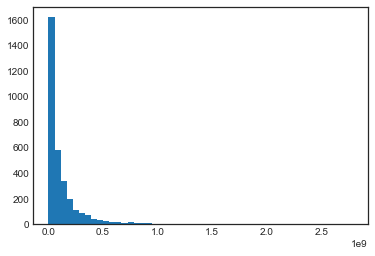

count    3.228000e+03
mean     1.213428e+08
std      1.862827e+08
min      1.030000e+02
25%      1.712699e+07
50%      5.519150e+07
75%      1.463434e+08
max      2.787965e+09
Name: revenue, dtype: float64

In [240]:
plt.hist(movies2.revenue, bins=50)
plt.show()

movies2.revenue.describe()

## Feature engineering

In [241]:
movies2['rev_ratio'] = movies2['revenue']/movies2['budget']
movies2['rev_ratio'].describe()


count     3228.000000
mean        12.744424
std        257.090166
min          0.000003
25%          1.025760
50%          2.300444
75%          4.420879
max      12890.386667
Name: rev_ratio, dtype: float64

In [242]:
#Inspect the extreme outlier at the max.
movies2.loc[movies2['rev_ratio'].idxmax()]

budget                             15000
id                                 23827
original_language                     en
popularity                       47.4568
release_date                  2007-09-14
revenue                        193355800
runtime                               86
title                Paranormal Activity
vote_average                         5.9
vote_count                          1316
Australia                              0
Belgium                                0
Brazil                                 0
Canada                                 0
China                                  0
Czech Republic                         0
Denmark                                0
France                                 0
Germany                                0
Hong Kong                              0
Hungary                                0
India                                  0
Ireland                                0
Italy                                  0
Japan           

While the rev_ratio value associated with Paranormal Activity is an extreme outlier, it is in fact accurate. Paranormal Activity, with its low budget and unexpectedly high revenue, will turn out to be a great example of a "sleeper hit".

In [243]:
#Extract year, month, day from release date.
movies2['release_date'] = pd.to_datetime(movies2['release_date'])
movies2['year'], movies2['month'], movies2['day'] = movies2['release_date'].dt.year, movies2['release_date'].dt.month, movies2['release_date'].dt.day
movies2 = movies2.drop(['release_date'], 1)

In [244]:
CPI = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/CPI.csv')
CPI['year'] = pd.to_numeric(CPI['year'], errors='coerce')

movies2 = pd.merge(movies2, CPI, on='year', how='inner')
movies2.head()

,budget,id,original_language,popularity,revenue,runtime,title,vote_average,vote_count,Australia,...,Thriller,War,Western,rev_ratio,year,month,day,Annual Average,Annual Percent Change,CPI
0,237000000,19995,en,150.437577,2787965087,162.0,Avatar,7.2,11800,0,...,0,0,0,11.763566,2009,12,10,214.5,-0.40%,1.140793
1,250000000,767,en,98.885637,933959197,153.0,Harry Potter and the Half-Blood Prince,7.4,5293,0,...,0,0,0,3.735837,2009,7,7,214.5,-0.40%,1.140793
2,150000000,8373,en,21.939663,836297228,150.0,Transformers: Revenge of the Fallen,6.0,3138,0,...,0,0,0,5.575315,2009,6,19,214.5,-0.40%,1.140793
3,200000000,534,en,71.862892,371353001,115.0,Terminator Salvation,5.9,2463,0,...,1,0,0,1.856765,2009,5,20,214.5,-0.40%,1.140793
4,200000000,14161,en,45.274225,769653595,158.0,2012,5.6,4903,0,...,0,0,0,3.848268,2009,10,10,214.5,-0.40%,1.140793


In [258]:
#Adjust for inflation
movies2['budget_adj'] = movies2['budget'] * movies2['CPI']
movies2['revenue_adj'] = movies2['revenue'] * movies2['CPI']
movies2 = movies2.drop(['Annual Average','Annual Percent Change','CPI'], 1)

In [259]:
movies2['revenue_adj'].describe()

count    2.748000e+03
mean     1.719135e+08
std      3.006680e+08
min      1.463653e+02
25%      2.609298e+07
50%      7.997818e+07
75%      1.989744e+08
max      7.044833e+09
Name: revenue_adj, dtype: float64

In [260]:
movies2['budget_adj'].describe()

count    2.748000e+03
mean     5.316289e+07
std      5.607152e+07
min      2.899163e+02
25%      1.700014e+07
50%      3.701117e+07
75%      7.415152e+07
max      1.302535e+09
Name: budget_adj, dtype: float64

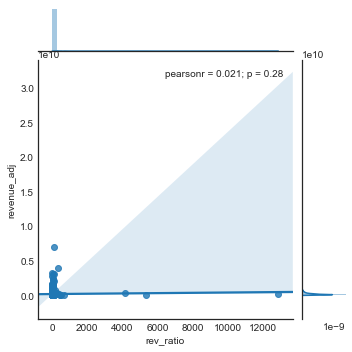

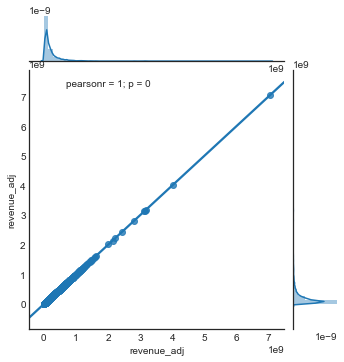

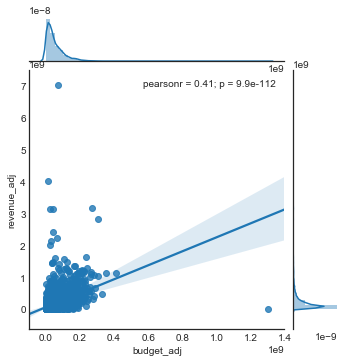

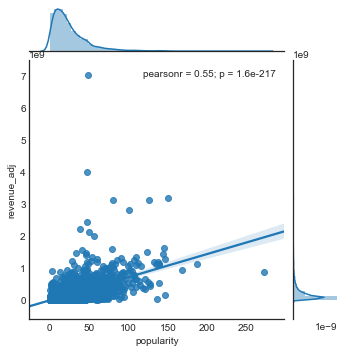

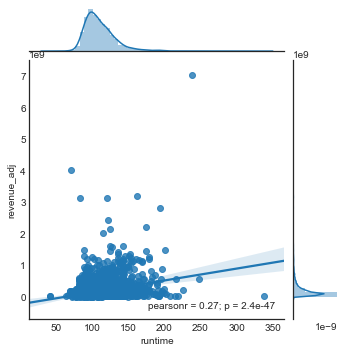

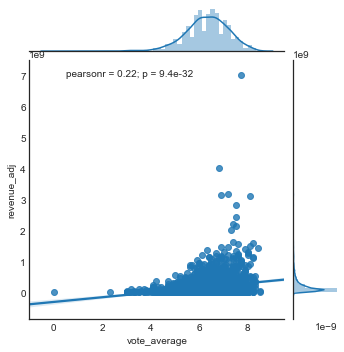

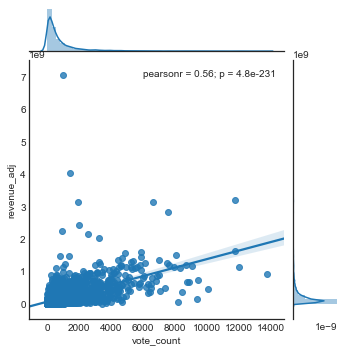

In [261]:
movies_continuous = movies2[['rev_ratio','revenue_adj','budget_adj','popularity','runtime','vote_average','vote_count']]
for col in movies_continuous:
    sns.jointplot(x=col, y='revenue_adj', data=movies_continuous, kind='reg', size=5)#etc 

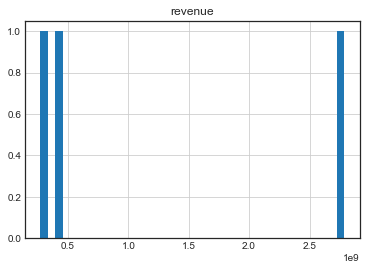

In [262]:
high = movies2[movies2['revenue_adj'] > movies2['revenue_adj'].quantile(q=0.999)]
high.revenue.hist(bins=40)
plt.title('revenue')
plt.show()

In [263]:
#Consider winsorizing outliers.

#boundary = movies2['revenue_adj'].quantile(q=0.999)
#movies2['revenue_adj'] = movies2['revenue_adj'].apply(lambda x: boundary if x>boundary else x)
#movies2.revenue_adj.hist(bins=40)
#plt.title('revenue_adj')
#plt.show()

              revenue_adj  rev_ratio  budget_adj  popularity   runtime  \
revenue_adj      1.000000   0.020601    0.409712    0.550449  0.270654   
rev_ratio        0.020601   1.000000   -0.037127    0.018337 -0.037574   
budget_adj       0.409712  -0.037127    1.000000    0.422082  0.290189   
popularity       0.550449   0.018337    0.422082    1.000000  0.235433   
runtime          0.270654  -0.037574    0.290189    0.235433  1.000000   
vote_average     0.221019   0.010225   -0.015730    0.391313  0.379629   
vote_count       0.564460   0.005933    0.413721    0.853070  0.245446   

              vote_average  vote_count  
revenue_adj       0.221019    0.564460  
rev_ratio         0.010225    0.005933  
budget_adj       -0.015730    0.413721  
popularity        0.391313    0.853070  
runtime           0.379629    0.245446  
vote_average      1.000000    0.384397  
vote_count        0.384397    1.000000  


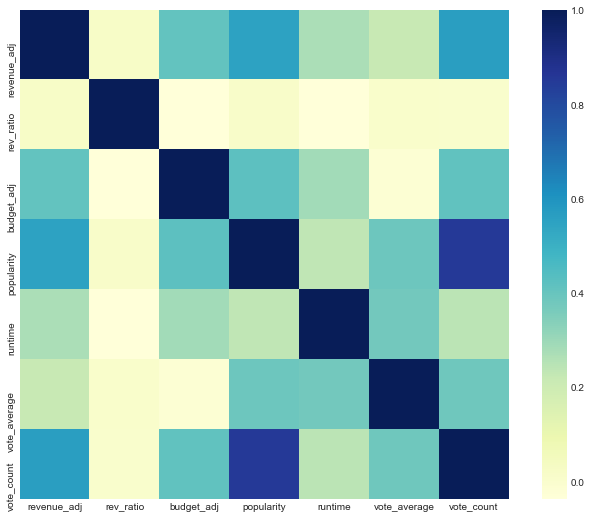

In [264]:
movies_continuous = movies2[['revenue_adj','rev_ratio','budget_adj','popularity','runtime','vote_average','vote_count']]

corrmat = movies_continuous.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=1, square=True, cmap="YlGnBu")
plt.show()

## Prepare data for modeling

In [265]:
#Split into train, tune, test
#normalize and scale

X = movies2.drop(['id','original_language','title','revenue','revenue_adj', 'budget'],1)
X = pd.get_dummies(X)

X.drop([col for col, val in X.sum().iteritems() if val < 3], axis=1, inplace=True)


In [266]:
null_count = X.isnull().sum()
null_count[null_count>0]

X[X.isnull().any(axis=1)]

,popularity,runtime,vote_average,vote_count,Australia,Belgium,Brazil,Canada,China,Czech Republic,...,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012


In [267]:
X = X.dropna(axis=1, how='any')
X[X.isnull().any(axis=1)]

,popularity,runtime,vote_average,vote_count,Australia,Belgium,Brazil,Canada,China,Czech Republic,...,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012


In [268]:
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

#X = pd.concat([X_scaled, late2['date']], axis=1)
Y = movies2['revenue_adj'].apply(lambda x: np.log(x))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, shuffle=True)

## Regression models

### OLS Regression

In [269]:
regr = linear_model.LinearRegression()
fit = regr.fit(X_train, y_train)
predict_train = fit.predict(X_train)

# Cross-validate.
score = cross_val_score(regr, X_train, y_train, cv=5)
print(score)

# Extract predicted values.
predicted = np.exp(regr.predict(X_train).ravel())
actual = np.exp(y_train)

rms = sqrt(mean_squared_error(actual, predicted))
print(rms)


[ 0.44479817  0.13539901  0.37496021 -5.26471771  0.29249814]
16219802553.390514


In [270]:
co_dict = {'features': X_train.columns.values, 'coefficients': fit.coef_}
ranked_co = pd.DataFrame(data=co_dict)
ranked_co['coef_absolute'] = abs(ranked_co['coefficients'])
ranked_co = ranked_co.sort_values('coef_absolute', ascending=False)
print(ranked_co)

     coefficients                  features  coef_absolute
0        0.678433                popularity       0.678433
84       0.432285                budget_adj       0.432285
146     -0.326272                 year_2011       0.326272
145     -0.293483                 year_2010       0.293483
144     -0.262507                 year_2009       0.262507
147     -0.244248                 year_2012       0.244248
141     -0.236809                 year_2006       0.236809
69       0.233745                    Family       0.233745
33       0.230896  United States of America       0.230896
143     -0.230666                 year_2008       0.230666
142     -0.196869                 year_2007       0.196869
140     -0.188586                 year_2005       0.188586
133     -0.177332                 year_1998       0.177332
68      -0.176101                     Drama       0.176101
136     -0.171380                 year_2001       0.171380
1        0.170148                   runtime       0.1701

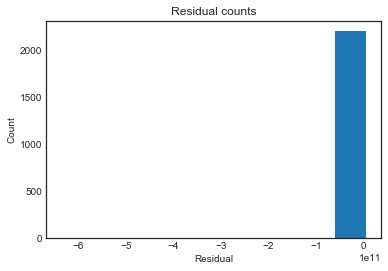

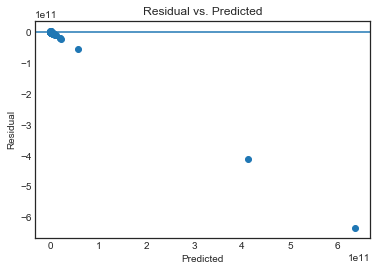

In [271]:
# Calculate the residual error.
residual = actual - predicted

#Check multivariate normality.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#Check homoscedasticity.
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Gradient Boosting

In [272]:
#Model outcome variable as a function (ratio of revenue to budget),
#in order to predict unobserved revenue values.
Y = movies2['rev_ratio']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, shuffle=True)

In [273]:
#TO BE TUNED!! Saving computational time for now.
model = ensemble.GradientBoostingRegressor(learning_rate=0.05, 
                                           min_samples_split=10,
                                           min_samples_leaf=50,
                                           n_estimators=80,
                                           max_depth=6,
                                           max_features='sqrt',
                                           subsample=0.8,
                                           random_state=10,
                                           loss='ls')

model.fit(X_train,y_train)
predict_train = model.predict(X_train)

print(cross_val_score(model, X_train, y_train, cv=5))
print(cross_val_score(model, X_train, y_train, cv=5).mean())


#Adjust so that we're still looking at rmse for revenue
predicted = model.predict(X_train).ravel()
actual = y_train

rms = sqrt(mean_squared_error(actual, predicted))
print(rms)

[  0.15475409 -13.94262174  -6.32177277   0.03040575   0.0737573 ]
-4.00109547175
293.8667242236555


### SVR

## Classification of sleeper hits

The criteria for identifying sleeper hits are abitrary. For the purposes of this exercise, we will identify a sleeper hit as a film whose revenue at least triples its budget, and which has a relatively low budget (less than 17 million dollars, adjusted). This threshold identifies roughly the bottom quartile of budgets.

In [274]:
movies2['hit'] = np.where(movies2['revenue']/movies2['budget']>3, 1, 0)
movies2['hit'].value_counts()


0    1683
1    1065
Name: hit, dtype: int64

In [275]:
movies2['sleeper'] = np.where(((movies2['hit']==1)&(movies2['budget_adj']<=17000000)),1, 0)
print(movies2['sleeper'].value_counts())
print(movies2[movies2['sleeper']==1])


0    2403
1     345
Name: sleeper, dtype: int64
        budget      id original_language  popularity    revenue  runtime  \
64    10000000   25793                en   18.664624   47536959    110.0   
124   11000000   22804                en   31.900899   68233629     90.0   
125   10000000   22824                en   22.888173   42333295     98.0   
130    7000000   25196                en   17.697042   39462438    112.0   
132    8000000   14536                en   13.987772   29010817     97.0   
134    7500000   24684                en   16.990308   26096852    100.0   
137    7500000   19913                en   45.610993   60722734     95.0   
138    7000000   12573                en   23.612409   31430334    105.0   
143    5600000   10664                es   22.341462   18469680     85.0   
145    5000000   31175                de    5.461487   17872796     99.0   
148    2000000   25376                es   25.894065   33965843    129.0   
224    9000000    2196                en

Note that the classes are quite imbalanced: only 345 out of 2403 films in the dataset (14%) count as sleeper hits. It will be crucial therefore, to ensure that the classifier is not simply identifying all films as non-sleeper hits for an accuracy rate of 86%. For this problem, recall is most important, so we will be paying close attention to how successfully the model affirmatively classifies true sleeper hits.

In [286]:
#Prepare the data for modeling.
X_scaled = X_scaled.drop(['budget_adj', 'rev_ratio'],1)
Y = movies2['sleeper']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, shuffle=True)


### Random Forest Classifier

In [287]:
#TO BE TUNED!
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train) 
cross_val_score(rfc, X_train, y_train, cv=10)


array([ 0.86877828,  0.85972851,  0.87330317,  0.86818182,  0.88636364,
        0.85844749,  0.87214612,  0.87671233,  0.88584475,  0.89041096])

In [288]:
y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.883636363636
             precision    recall  f1-score   support

          0       0.89      1.00      0.94       480
          1       0.80      0.11      0.20        70

avg / total       0.87      0.88      0.84       550



### Logistic Regression

Ridge regression:

In [289]:
# Declare and fit the ridge model.
def log_ridge_run(X_train, y_train, c):
    ridge = LogisticRegression(C=c, penalty='l2', fit_intercept=False)
    ridge.fit(X_train, y_train)   
    print('Ridge Regression results:\n')
    print('Regularization: ', c)
    print('Accuracy, 5 folds: ', cross_val_score(ridge, X_train, y_train, cv=5))
    avg_score = cross_val_score(ridge, X_train, y_train, cv=5).mean()
    print('Average CV score: ', avg_score)
    y_pred = ridge.predict(X_train)
    print('Accuracy, test:\n ', classification_report(y_train, y_pred))
    return avg_score

def log_ridge_tune(X_train, 
                 y_train, 
                 C = [1, 10, 25, 50, 100, 500, 1000]):
    results = pd.DataFrame(columns=['Regularization','Accuracy'])
    results['Regularization'] = C
    results = results.set_index('Regularization')
    accuracy = []
    for c in C:
        score = log_ridge_run(X_train, y_train, c)
        accuracy.append(score)
    results['Accuracy'] = accuracy
    results = results.sort_values('Accuracy', ascending=False)
    return print('Results :\n', results)


In [290]:
log_ridge_tune(X_train, y_train)

Ridge Regression results:

Regularization:  1
Accuracy, 5 folds:  [ 0.84090909  0.86363636  0.82272727  0.82232346  0.85649203]
Average CV score:  0.841217643404
Accuracy, test:
               precision    recall  f1-score   support

          0       0.93      0.94      0.93      1923
          1       0.54      0.50      0.52       275

avg / total       0.88      0.88      0.88      2198

Ridge Regression results:

Regularization:  10
Accuracy, 5 folds:  [ 0.86590909  0.86363636  0.83863636  0.8405467   0.87699317]
Average CV score:  0.857144336302
Accuracy, test:
               precision    recall  f1-score   support

          0       0.91      0.97      0.94      1923
          1       0.65      0.34      0.45       275

avg / total       0.88      0.89      0.88      2198

Ridge Regression results:

Regularization:  25
Accuracy, 5 folds:  [ 0.86590909  0.87045455  0.83863636  0.83826879  0.88154897]
Average CV score:  0.858963553531
Accuracy, test:
               precision    re

In [291]:
ridge = LogisticRegression(C=500, penalty='l2', fit_intercept=False)
ridge.fit(X_train, y_train) 
y_pred = ridge.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.858181818182
             precision    recall  f1-score   support

          0       0.90      0.94      0.92       480
          1       0.41      0.27      0.33        70

avg / total       0.84      0.86      0.85       550



In [292]:
co_dict = {'features': X_train.columns.values, 'coefficients': ridge.coef_[0]}
ranked_co = pd.DataFrame(data=co_dict)
ranked_co['coef_absolute'] = abs(ranked_co['coefficients'])
ranked_co = ranked_co.sort_values('coef_absolute', ascending=False)
print(ranked_co)

     coefficients                  features  coef_absolute
108     46.565896                 year_1975      46.565896
1       -0.779439                   runtime       0.779439
2        0.539668              vote_average       0.539668
142     -0.423889                 year_2009       0.423889
64      -0.417189                 Animation       0.417189
143     -0.379368                 year_2010       0.379368
131     -0.364415                 year_1998       0.364415
140     -0.361781                 year_2007       0.361781
141     -0.356629                 year_2008       0.356629
136     -0.346927                 year_2003       0.346927
137     -0.343388                 year_2004       0.343388
33      -0.340227  United States of America       0.340227
139     -0.334860                 year_2006       0.334860
138     -0.334837                 year_2005       0.334837
133     -0.320984                 year_2000       0.320984
134     -0.319777                 year_2001       0.3197

In [293]:
# Declare and fit the lasso model.

def log_lasso_run(X_train, y_train, c):
    lasso = LogisticRegression(C=c, penalty='l1', fit_intercept=False)
    lasso.fit(X_train, y_train)   
    print('Lasso Regression results:\n')
    print('Regularization: ', c)
    print('Accuracy, 5 folds: ', cross_val_score(lasso, X_train, y_train, cv=5))
    avg_score = cross_val_score(lasso, X_train, y_train, cv=5).mean()
    print('Average CV score: ', avg_score)
    y_pred = lasso.predict(X_train)
    print('Accuracy, test:\n ', classification_report(y_train, y_pred))
    return avg_score

def log_lasso_tune(X_train, 
                 y_train, 
                 C = [0.001, 0.1, 1, 10, 50, 100, 500, 1000]):#
    results = pd.DataFrame(columns=['Regularization','Accuracy'])
    results['Regularization'] = C
    results = results.set_index('Regularization')
    accuracy = []
    for c in C:
        score = log_lasso_run(X_train, y_train, c)
        accuracy.append(score)
    results['Accuracy'] = accuracy
    results = results.sort_values('Accuracy', ascending=False)
    return print('Results :\n', results)

In [294]:
log_lasso_tune(X_train, y_train)

Lasso Regression results:

Regularization:  0.001
Accuracy, 5 folds:  [ 0.875       0.875       0.875       0.87471526  0.87471526]
Average CV score:  0.874886104784
Accuracy, test:
               precision    recall  f1-score   support

          0       0.87      1.00      0.93      1923
          1       0.00      0.00      0.00       275

avg / total       0.77      0.87      0.82      2198

Lasso Regression results:

Regularization:  0.1


/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy, 5 folds:  [ 0.88181818  0.87727273  0.85681818  0.85421412  0.87243736]
Average CV score:  0.868512114309
Accuracy, test:
               precision    recall  f1-score   support

          0       0.90      0.98      0.94      1923
          1       0.67      0.27      0.38       275

avg / total       0.87      0.89      0.87      2198

Lasso Regression results:

Regularization:  1
Accuracy, 5 folds:  [ 0.87272727  0.87727273  0.85        0.84738041  0.88382688]
Average CV score:  0.865786912404
Accuracy, test:
               precision    recall  f1-score   support

          0       0.91      0.98      0.94      1923
          1       0.64      0.30      0.41       275

avg / total       0.87      0.89      0.87      2198

Lasso Regression results:

Regularization:  10
Accuracy, 5 folds:  [ 0.86818182  0.87045455  0.84772727  0.8428246   0.87927107]
Average CV score:  0.863057568855
Accuracy, test:
               precision    recall  f1-score   support

          0       0.9

In [295]:
lasso = LogisticRegression(C=50, penalty='l1', fit_intercept=False)
lasso.fit(X_train, y_train) 
y_pred = lasso.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.854545454545
             precision    recall  f1-score   support

          0       0.90      0.94      0.92       480
          1       0.39      0.24      0.30        70

avg / total       0.83      0.85      0.84       550



In [296]:
co_dict = {'features': X_train.columns.values, 'coefficients': lasso.coef_[0]}
ranked_co = pd.DataFrame(data=co_dict)
ranked_co['coef_absolute'] = abs(ranked_co['coefficients'])
ranked_co = ranked_co.sort_values('coef_absolute', ascending=False)
print(ranked_co)

     coefficients                  features  coef_absolute
108     33.094786                 year_1975      33.094786
107      0.944754                 year_1974       0.944754
1       -0.519381                   runtime       0.519381
2        0.365891              vote_average       0.365891
33      -0.267662  United States of America       0.267662
64      -0.259403                 Animation       0.259403
73       0.185590                    Horror       0.185590
67       0.151880               Documentary       0.151880
109      0.142373                 year_1976       0.142373
29       0.141673                    Sweden       0.141673
11      -0.140191                    France       0.140191
71      -0.140115                   Foreign       0.140115
70      -0.137098                   Fantasy       0.137098
131     -0.136361                 year_1998       0.136361
63      -0.133464                 Adventure       0.133464
36      -0.133098                   English       0.1330

### SVC

In [ ]:
## Define a function to run a grid search to tune hyperparameters
## for a linear SVC
def svc_run(X_train, y_train, c, pen):
    svc = LinearSVC(C=c, penalty=pen, dual=False, random_state=10)
    svc.fit(X_train, y_train)
    print('SCV results:\n')
    print('Regularization: ', pen, ' = ', c)
    print('Accuracy, 5 folds: ', cross_val_score(svc, X_train, y_train, cv=5))
    avg_score = cross_val_score(svc, X_train, y_train, cv=5).mean()
    print('Average CV score: ', avg_score)
    y_pred = svc.predict(X_train)
    print('Accuracy, test:\n ', classification_report(y_train, y_pred)) 

def linear_svc_tune(X_train, y_train, C=[1e-7, 1e-3, 0.1, 0.25, 0.5, 1, 100, 1000, 1e5]):
    penalties = ['l1','l2']
    for pen in penalties:
        for c in C:
            svc_run(X_train, y_train, c, pen)

In [ ]:
linear_svc_tune(X_train, y_train)

In [306]:
#Try to run all at once; at least the three most important. 
#If not, do one at a time and then mess around by hand.
param_test1 = [{'C':[1e-3, 0.1, 0.25, 0.5, 1, 100, 1000], 
                'penalty':['l1','l2'],
               }]
svc = LinearSVC(class_weight='balanced', dual=False)
gsearch1 = GridSearchCV(svc, param_test1, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.1, 0.25, 0.5, 1, 100, 1000], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [307]:
gsearch1.grid_scores_

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.87489, std: 0.00014, params: {'C': 0.001, 'penalty': 'l1'},
 mean: 0.71747, std: 0.01810, params: {'C': 0.001, 'penalty': 'l2'},
 mean: 0.76206, std: 0.01523, params: {'C': 0.1, 'penalty': 'l1'},
 mean: 0.76069, std: 0.01635, params: {'C': 0.1, 'penalty': 'l2'},
 mean: 0.76388, std: 0.01351, params: {'C': 0.25, 'penalty': 'l1'},
 mean: 0.76024, std: 0.01906, params: {'C': 0.25, 'penalty': 'l2'},
 mean: 0.76251, std: 0.01512, params: {'C': 0.5, 'penalty': 'l1'},
 mean: 0.76024, std: 0.01846, params: {'C': 0.5, 'penalty': 'l2'},
 mean: 0.76160, std: 0.01679, params: {'C': 1, 'penalty': 'l1'},
 mean: 0.76069, std: 0.01782, params: {'C': 1, 'penalty': 'l2'},
 mean: 0.76024, std: 0.01708, params: {'C': 100, 'penalty': 'l1'},
 mean: 0.76115, std: 0.01803, params: {'C': 100, 'penalty': 'l2'},
 mean: 0.76069, std: 0.01732, params: {'C': 1000, 'penalty': 'l1'},
 mean: 0.76115, std: 0.01803, params: {'C': 1000, 'penalty': 'l2'}]

In [308]:
gsearch1.best_params_

{'C': 0.001, 'penalty': 'l1'}

In [303]:
gsearch1.best_score_

0.87488626023657867

In [309]:
svc = LinearSVC(class_weight='balanced', dual=False, C=0.001, penalty='l1')

svc.fit(X_train,y_train)
predict_train = svc.predict(X_train)

print(cross_val_score(svc, X_train, y_train, cv=5))
print(cross_val_score(svc, X_train, y_train, cv=5).mean())

# Accuracy tables.
print(classification_report(y_train, predict_train))
table_train = pd.crosstab(y_train, predict_train, margins=True)
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

[ 0.875       0.875       0.875       0.87471526  0.87471526]
0.874886104784
             precision    recall  f1-score   support

          0       0.89      0.92      0.91      1923
          1       0.29      0.22      0.25       275

avg / total       0.82      0.83      0.82      2198

Training set accuracy:
Percent Type I errors: 0.06869881710646042
Percent Type II errors: 0.09736123748862602




### Gradient Boosting Classifier

In [ ]:
#Try to run all at once; at least the three most important. If not, do one at a time and then mess around by hand.
param_test1 = [{'n_estimators':[40, 60, 80, 100], 
                'learning_rate':[0.001, 0.05, 0.1, 0.2],
               'max_depth':[2, 3, 4, 6, 8],
                'min_samples_split':[10, 50, 100, 200], 
                'min_samples_leaf':[10,20,50,100,200],
               'subsample':[0.7, 0.8, 0.9], 
                'max_features':['sqrt','log2']
               }]
gbc = ensemble.GradientBoostingClassifier(random_state=10,
                                          loss='deviance')
gsearch1 = GridSearchCV(gbc, 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)
gsearch1.fit(X_train,y_train)

In [ ]:
gsearch1.grid_scores_

In [ ]:
gsearch1.best_score_

In [ ]:
gbc = ensemble.GradientBoostingClassifier(random_state=10,
                                          loss='deviance',
                                          n_estimators=,
                                          learning_rate=,
                                          max_depth=,
                                          min_samples_split=,
                                          min_samples_leaf=,
                                          subsample=,
                                          max_features=
)

gbc.fit(X_train,y_train)
predict_train = gbc.predict(X_train)

print(cross_val_score(gbc, X_train, y_train, cv=5))
print(cross_val_score(gbc, X_train, y_train, cv=5).mean())

# Accuracy tables.
print(classification_report(y_train, predict_train))
table_train = pd.crosstab(y_train, predict_train, margins=True)
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

In [ ]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()